# Changing_Clothes_Images_2018

Silhouette Segmentation using Deep Lab

In [1]:
# Importing Libraries

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import measure

#tensorflow_version 1.x
import tensorflow as tf

#from pyefd import elliptic_fourier_descriptors

print('Done.............')

/home/acw441/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/acw441/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/acw441/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/acw441/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

Done.............


/home/acw441/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/acw441/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/acw441/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/acw441/.local/lib/python3.6/site-packages/tensorboard/compat/ten

In [2]:
# Importing Helper Methods

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

print('Done.............')

Done.............


In [3]:
#Select a Pre-Trained Model

MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

print('Done.............')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!
Done.............


running deeplab on image https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image3.jpg?raw=true...


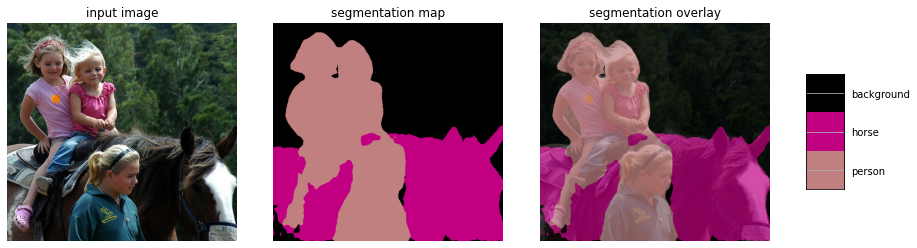

<class 'numpy.ndarray'>
(487, 513)
Done.............


In [4]:
#Running Deep Lab on Sample Image


SAMPLE_IMAGE = 'image3'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)

  return seg_map


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
out_seg_map = run_visualization(image_url)

print(type(out_seg_map))
print(out_seg_map.shape)

print('Done.............')

<class 'PIL.Image.Image'>
Done.............


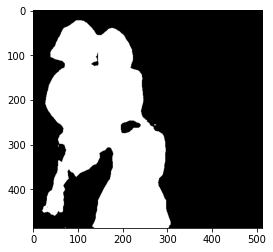

In [5]:
# Developing Person Silhouette from Segmentation Map 

import numpy as np
from PIL import Image

arr_zeros = np.zeros([out_seg_map.shape[0],out_seg_map.shape[1]])

for row in range(out_seg_map.shape[0]):
  for col in range(out_seg_map.shape[1]):
    if out_seg_map[row][col] == 15:
      arr_zeros[row][col] = 255
    else:
      arr_zeros[row][col] = 0

zero_img = Image.fromarray(arr_zeros)
plt.imshow(zero_img)
print(type(zero_img))

print('Done.............')

In [6]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_silhouette_2018/',str(dir_names[dir])))
 

for dir_idx in range(12):
    sub_dir = parent_dir +  str(dir_names[dir_idx])
    print(sub_dir + '................................................................................')
    for image_file in os.listdir(sub_dir):
        input_image = Image.open(os.path.join(sub_dir,image_file))
        resized_im, seg_map = MODEL.run(input_image)
        temp_zeros_arr = np.zeros([seg_map.shape[0],seg_map.shape[1]])
        for x_idx in range(seg_map.shape[0]):
            for y_idx in range(seg_map.shape[1]):
                if seg_map[x_idx][y_idx] == 15:
                    temp_zeros_arr[x_idx][y_idx] = 255
                else:
                    temp_zeros_arr[x_idx][y_idx] = 0
        #print(image_file)
        status = cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_silhouette_2018/' + str(dir_names[dir_idx]),image_file),temp_zeros_arr)
        if status == False:
            print(status)
print('Done......................................................................................................')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/1................................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/2................................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/4................................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/7................................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/8................................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projec

Drawing Biggest Area Object in the Silhouette Image

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/changing_clothes_silhouette_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/biggest_silhouette_images_2018/',str(dir_names[dir])))


for dir_idx in range(12):
    sub_dir = parent_dir +  str(dir_names[dir_idx])
    print(sub_dir)
    for image_file in os.listdir(sub_dir):
        #print(image_file)
        temp_image = np.zeros([288,513])
        bgr_image = cv2.imread(os.path.join(sub_dir,image_file))
        gray_image = cv2.cvtColor(bgr_image,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(gray_image,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        contours_area = []
        
        for c_idx in range(len(contours)):
            contours_area.append(cv2.contourArea(contours[c_idx]))
        
        if len(contours_area) > 0:
            max_idx = contours_area.index(max(contours_area))
            cv2.fillPoly(temp_image, pts = [contours[max_idx]], color = (255,255,255))
            status = cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/biggest_silhouette_images_2018/' + str(dir_names[dir_idx]),image_file),temp_image)
            if status == False:
                print(status)
        #cv2.drawContours(bgr_image, contours, max_idx, (0,255,0), 3)
        
        
    print('Next....................................................................')




print('Done..................................................................................................')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/changing_clothes_silhouette_2018/1
Next....................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/changing_clothes_silhouette_2018/2
Next....................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/changing_clothes_silhouette_2018/4
Next....................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/changing_clothes_silhouette_2018/7
Next....................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/changing_clothes_silhouette_2018/8
Next....

Computing Area of Silhouette in the Image

In [2]:
import os
import cv2
import numpy as np
import xlsxwriter
from matplotlib import pyplot as plt


parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/biggest_silhouette_images_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

workbook = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/area_silhouette_2018.xlsx')

for dir_idx in range(12):
    sub_dir = parent_dir +  str(dir_names[dir_idx])
    print(sub_dir)
    worksheet = workbook.add_worksheet()
    worksheet.write('A1', 'Image ID')
    worksheet.write('B1', 'Contour Area')
    images_names = []
    images_contour_area = []
    for image_file in os.listdir(sub_dir):
        #print(image_file)
        images_names.append(image_file)
        bgr_image = cv2.imread(os.path.join(sub_dir,image_file))
        gray_image = cv2.cvtColor(bgr_image,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(gray_image,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        images_contour_area.append(cv2.contourArea(contours[0]))
    #print(len(images_names))
    #print(len(images_contour_area))
    for r_idx in range(len(images_names)):
        worksheet.write(r_idx + 1, 0, images_names[r_idx])
        worksheet.write(r_idx + 1, 1, images_contour_area[r_idx])

    print('Next....................................................................')

workbook.close()

print('Done.............')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/biggest_silhouette_images_2018/1
Next....................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/biggest_silhouette_images_2018/2
Next....................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/biggest_silhouette_images_2018/4
Next....................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/biggest_silhouette_images_2018/7
Next....................................................................
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/biggest_silhouette_images_2018/8
Next..............

Saving Best Full Silhouette Image (190 for each Object)

In [5]:
import pandas as pd
import shutil


parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/biggest_silhouette_images_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/best_silhouette_images_2018/',str(dir_names[dir])))

xlsx = pd.ExcelFile('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/area_silhouette_2018.xlsx')

for sheet_idx in range(12):
    df = pd.read_excel('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/area_silhouette_2018.xlsx',xlsx.sheet_names[sheet_idx])
    temp_df = pd.DataFrame(data=df)

    sorted_temp_df = temp_df.sort_values(by='Contour Area',ascending=False)
    
    best_190_df = pd.DataFrame(columns=['Image ID', 'Contour Area'])

    for row in range(190):
        best_190_df = best_190_df.append({'Image ID':sorted_temp_df.iloc[row,0], 'Contour Area':sorted_temp_df.iloc[row,1]},ignore_index=True)

    for dir_idx in range(1):
        sub_dir = parent_dir +  str(dir_names[sheet_idx])
        for r_idx in range(190):
            image_name = sub_dir + '/' + best_190_df.iloc[r_idx,0]
            shutil.copy(image_name,'/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/best_silhouette_images_2018/'+str(dir_names[sheet_idx]) + '/' + best_190_df.iloc[r_idx,0],follow_symlinks=True)
            
print('Done.......................................................................................')


Done.......................................................................................


Cropping Bounding Box

In [15]:
import os
import cv2
import numpy as np



def crop_rect(img, rect):
    # get the parameter of the small rectangle
    center, size, angle = rect[0], rect[1], rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))

    # get row and col num in img
    height, width = img.shape[0], img.shape[1]

    # calculate the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1)
    
    # rotate the original image
    img_rot = cv2.warpAffine(img, M, (width, height))

    # now rotated rectangle becomes vertical and we crop it
    img_crop = cv2.getRectSubPix(img_rot, size, center)

    return img_crop, img_rot


parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/best_silhouette_images_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/temp_full_body_silhouette_images_2018/',str(dir_names[dir])))


for dir_idx in range(12):
    sub_dir = parent_dir +  str(dir_names[dir_idx])
    print(sub_dir)
    for image_file in os.listdir(sub_dir):
        print(image_file)
        bgr_image = cv2.imread(os.path.join(sub_dir,image_file))
        gray_image = cv2.cvtColor(bgr_image,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(gray_image,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        rect = cv2.minAreaRect(contours[0])
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        #cv2.drawContours(bgr_image,[box],0,(0,0,255),2)
        img_crop, img_rot = crop_rect(bgr_image, rect)
        cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/temp_full_body_silhouette_images_2018/' + str(dir_names[dir_idx]),image_file), img_crop)




print('Done.............................')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/best_silhouette_images_2018/1
7_00354.png
7_00360.png
7_00392.png
8_00314.png
7_00420.png
7_00338.png
9_00358.png
8_00310.png
8_00386.png
8_00388.png
8_00352.png
9_00390.png
7_00404.png
9_00360.png
7_00342.png
7_00388.png
9_00372.png
7_00382.png
8_00332.png
9_00398.png
9_00386.png
9_00322.png
7_00326.png
8_00350.png
8_00342.png
7_00366.png
9_00352.png
8_00366.png
9_00330.png
9_00384.png
8_00364.png
9_00382.png
8_00300.png
8_00340.png
8_00368.png
7_00394.png
7_00324.png
9_00396.png
9_00346.png
7_00412.png
9_00310.png
8_00306.png
8_00308.png
8_00326.png
9_00406.png
9_00408.png
7_00386.png
9_00366.png
8_00302.png
9_00350.png
9_00316.png
8_00360.png
7_00294.png
8_00290.png
7_00402.png
9_00354.png
7_00422.png
7_00408.png
9_00296.png
9_00324.png
8_00356.png
8_00346.png
7_00380.png
8_00282.png
9_00300.png
8_00324.png
9_00380.png
9_00312.png
8_00382.png
8_00334.png
8_00316.png
7_00312.png
7

8_00394.png
9_00394.png
9_00378.png
9_00444.png
7_00330.png
8_00392.png
9_00432.png
8_00344.png
7_00428.png
7_00374.png
8_00390.png
7_00456.png
7_00390.png
7_00336.png
7_00396.png
8_00412.png
7_00442.png
9_00474.png
9_00414.png
7_00332.png
8_00370.png
9_00392.png
9_00470.png
9_00458.png
8_00320.png
7_00370.png
9_00376.png
8_00410.png
9_00450.png
9_00446.png
7_00410.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/best_silhouette_images_2018/8
7_00354.png
7_00360.png
7_00392.png
9_00422.png
7_00420.png
9_00410.png
7_00338.png
7_00450.png
9_00358.png
8_00386.png
8_00388.png
8_00352.png
9_00390.png
7_00404.png
9_00360.png
7_00342.png
7_00388.png
9_00434.png
9_00372.png
7_00382.png
9_00398.png
9_00386.png
9_00322.png
7_00326.png
8_00350.png
8_00342.png
7_00366.png
9_00352.png
8_00366.png
9_00440.png
9_00330.png
9_00384.png
7_00438.png
8_00364.png
9_00382.png
9_00428.png
8_00340.png
8_00368.png
7_00394.png
7_00324.png
8_00424.png
9

9_00354.png
7_00422.png
8_00428.png
7_00408.png
8_00462.png
9_00442.png
9_00462.png
7_00380.png
7_00454.png
7_00424.png
9_00380.png
8_00430.png
8_00382.png
7_00460.png
8_00446.png
8_00466.png
7_00444.png
7_00416.png
7_00418.png
7_00358.png
8_00418.png
7_00364.png
7_00356.png
7_00446.png
7_00400.png
9_00460.png
9_00466.png
7_00434.png
8_00452.png
7_00362.png
8_00378.png
8_00472.png
8_00380.png
8_00384.png
7_00406.png
9_00448.png
9_00430.png
9_00456.png
8_00478.png
9_00424.png
8_00470.png
9_00356.png
9_00476.png
9_00368.png
8_00422.png
8_00442.png
7_00458.png
8_00406.png
9_00438.png
9_00400.png
9_00416.png
9_00374.png
7_00368.png
7_00468.png
7_00334.png
8_00454.png
8_00376.png
8_00372.png
7_00340.png
7_00344.png
8_00414.png
8_00396.png
9_00370.png
7_00350.png
7_00464.png
8_00400.png
7_00398.png
7_00466.png
7_00348.png
8_00456.png
8_00398.png
7_00384.png
8_00458.png
7_00346.png
7_00426.png
7_00376.png
8_00468.png
9_00436.png
9_00472.png
8_00408.png
9_00418.png
8_00450.png
7_00372.png
8_00

7_00280.png
8_00344.png
9_00286.png
7_00318.png
8_00284.png
9_00336.png
7_00298.png
7_00374.png
7_00310.png
8_00390.png
7_00300.png
7_00288.png
7_00390.png
8_00296.png
7_00336.png
7_00396.png
8_00294.png
9_00364.png
9_00342.png
9_00334.png
7_00332.png
8_00370.png
9_00392.png
8_00320.png
7_00370.png
9_00376.png
9_00288.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/best_silhouette_images_2018/77
7_00354.png
7_00360.png
7_00392.png
9_00422.png
7_00420.png
9_00410.png
7_00338.png
7_00450.png
9_00358.png
8_00386.png
8_00388.png
8_00352.png
9_00390.png
7_00404.png
9_00360.png
7_00342.png
7_00388.png
9_00434.png
9_00372.png
7_00382.png
9_00398.png
9_00386.png
8_00350.png
7_00366.png
9_00352.png
8_00366.png
9_00440.png
9_00384.png
7_00438.png
8_00364.png
9_00382.png
9_00428.png
8_00368.png
7_00394.png
8_00424.png
9_00396.png
9_00346.png
7_00412.png
7_00430.png
8_00440.png
8_00438.png
9_00406.png
9_00408.png
7_00386.png
9_00366.png


Rotating Bounding Box

In [16]:
parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/temp_full_body_silhouette_images_2018/'

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_silhouette_images_2018/',str(dir_names[dir])))

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]
    
for dir_idx in range(12):
    sub_dir = parent_dir +  str(dir_names[dir_idx])
    print(sub_dir)
    for image_file in os.listdir(sub_dir):
        #print(image_file)
        bgr_image = cv2.imread(os.path.join(sub_dir,image_file))
        height, width, channel = bgr_image.shape
        if height < width:
            img_rotate_90_counterclockwise = cv2.rotate(bgr_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_silhouette_images_2018/' + str(dir_names[dir_idx]),image_file),img_rotate_90_counterclockwise)
        else:
            cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_silhouette_images_2018/' + str(dir_names[dir_idx]),image_file),bgr_image)

print('Done.............................')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/temp_full_body_silhouette_images_2018/1
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/temp_full_body_silhouette_images_2018/2
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/temp_full_body_silhouette_images_2018/4
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/temp_full_body_silhouette_images_2018/7
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/temp_full_body_silhouette_images_2018/8
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/temp_full_body_silhouette_images_2018/12
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/temp_full_body_silhouett

full_body_2018

In [17]:
import math
import os
import cv2

parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_silhouette_images_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/',str(dir_names[dir])))

    
for dir_idx in range(12):
    sub_dir = parent_dir +  str(dir_names[dir_idx])
    print(sub_dir)
    for image_file in os.listdir(sub_dir):
        #print(image_file)
        cropped_image = cv2.imread(os.path.join(sub_dir,image_file))
        width, height = cropped_image.shape[1], cropped_image.shape[0]
        imgray = cv2.cvtColor(cropped_image,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(imgray,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 1:
            print(image_file)
        else:
            cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/' + str(dir_names[dir_idx]),image_file),cropped_image)
        
print('Done..........................................................................................')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_silhouette_images_2018/1
8_00342.png
8_00354.png
8_00344.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_silhouette_images_2018/2
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_silhouette_images_2018/4
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_silhouette_images_2018/7
8_00386.png
9_00442.png
7_00364.png
8_00390.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_silhouette_images_2018/8
9_00414.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_silhouette_images_2018/12
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_proj

head_neck_2018

In [30]:
import math
import os
import cv2
import numpy as np

!rm -r head_neck_2018

parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/head_neck_2018/',str(dir_names[dir])))


for dir_idx in range(12):
    sub_dir = parent_dir + str(dir_names[dir_idx])
    print(sub_dir)
    for image_file in os.listdir(sub_dir):
        print(image_file)
        cropped_image = cv2.imread(os.path.join(sub_dir,image_file))
        width, height = cropped_image.shape[1], cropped_image.shape[0]
        head_neck_region_height = int((15/100) * height)
        #print(head_neck_region_height)
        head_neck_region = cropped_image[0 : head_neck_region_height, 0 : width]
        
        imgray = cv2.cvtColor(head_neck_region,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(imgray,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 1:
            print(image_file)
        else:
            cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/head_neck_2018/' + str(dir_names[dir_idx]),image_file),head_neck_region)
        
print('Done..........................................................................................')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/1
7_00354.png
7_00360.png
7_00392.png
8_00314.png
7_00420.png
7_00338.png
9_00358.png
8_00310.png
8_00386.png
8_00388.png
8_00352.png
9_00390.png
7_00404.png
9_00360.png
7_00342.png
7_00388.png
9_00372.png
7_00382.png
8_00332.png
9_00398.png
9_00386.png
9_00322.png
7_00326.png
8_00350.png
7_00366.png
9_00352.png
8_00366.png
9_00330.png
9_00384.png
8_00364.png
9_00382.png
8_00300.png
8_00340.png
8_00368.png
7_00394.png
7_00324.png
9_00396.png
9_00346.png
7_00412.png
9_00310.png
8_00306.png
8_00308.png
8_00326.png
9_00406.png
9_00408.png
7_00386.png
9_00366.png
8_00302.png
9_00350.png
9_00316.png
8_00360.png
7_00294.png
8_00290.png
7_00402.png
9_00354.png
7_00422.png
7_00408.png
9_00296.png
9_00324.png
8_00356.png
8_00346.png
7_00380.png
8_00282.png
9_00300.png
8_00324.png
9_00380.png
9_00312.png
8_00382.png
8_00334.png
8_00316.png
7_00312.png
7_00328.png
8_00336.png
7_

9_00318.png
9_00356.png
9_00368.png
8_00422.png
8_00442.png
8_00358.png
8_00406.png
9_00438.png
9_00400.png
9_00416.png
9_00374.png
7_00368.png
7_00334.png
8_00454.png
8_00376.png
8_00372.png
7_00340.png
7_00344.png
8_00414.png
8_00396.png
9_00320.png
9_00370.png
7_00350.png
8_00338.png
9_00340.png
8_00400.png
7_00398.png
7_00348.png
8_00456.png
8_00398.png
7_00384.png
8_00458.png
9_00326.png
8_00348.png
7_00346.png
7_00426.png
7_00376.png
9_00436.png
8_00408.png
9_00418.png
8_00450.png
7_00372.png
8_00420.png
9_00402.png
9_00388.png
8_00436.png
8_00402.png
9_00332.png
7_00352.png
9_00404.png
9_00420.png
7_00452.png
9_00426.png
7_00448.png
8_00416.png
7_00378.png
8_00448.png
8_00426.png
7_00436.png
8_00404.png
7_00440.png
7_00414.png
7_00432.png
8_00432.png
8_00374.png
8_00394.png
8_00434.png
9_00394.png
9_00378.png
7_00330.png
8_00392.png
9_00348.png
9_00362.png
9_00432.png
8_00344.png
9_00336.png
7_00428.png
7_00374.png
8_00390.png
7_00390.png
7_00336.png
7_00396.png
8_00444.png
8_00

8_00340.png
8_00368.png
7_00394.png
7_00324.png
8_00424.png
9_00396.png
9_00346.png
7_00412.png
7_00430.png
8_00326.png
9_00406.png
9_00408.png
7_00386.png
9_00366.png
9_00350.png
9_00316.png
9_00412.png
8_00360.png
7_00294.png
7_00402.png
9_00354.png
7_00422.png
8_00428.png
7_00408.png
9_00442.png
9_00324.png
8_00356.png
8_00346.png
7_00380.png
8_00324.png
7_00424.png
9_00380.png
8_00430.png
8_00382.png
8_00334.png
7_00312.png
7_00328.png
8_00336.png
7_00416.png
7_00418.png
9_00344.png
7_00358.png
8_00328.png
8_00418.png
7_00364.png
7_00356.png
7_00296.png
9_00338.png
8_00354.png
7_00400.png
9_00328.png
7_00434.png
7_00362.png
8_00378.png
7_00302.png
7_00316.png
8_00330.png
8_00380.png
8_00362.png
8_00384.png
7_00406.png
9_00430.png
7_00320.png
9_00424.png
9_00318.png
9_00356.png
9_00368.png
8_00422.png
8_00358.png
8_00406.png
7_00304.png
7_00304.png
7_00306.png
9_00438.png
9_00400.png
9_00416.png
9_00374.png
7_00368.png
7_00334.png
8_00376.png
8_00372.png
7_00340.png
7_00344.png
8_00

shoulders_2018

In [31]:
import math
import os
import cv2

parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/shoulders_2018/',str(dir_names[dir])))


for dir_idx in range(12):
    sub_dir = parent_dir +  str(dir_names[dir_idx])
    print(sub_dir)
    for image_file in os.listdir(sub_dir):
        #print(image_file)
        cropped_image = cv2.imread(os.path.join(sub_dir,image_file))
        width, height = cropped_image.shape[1], cropped_image.shape[0]
        head_neck_region_height = int((15/100) * height)
        shoulders_region_height = int((29/100) * height)
        #print(shoulders_region_height)
        shoulder_region = cropped_image[head_neck_region_height : shoulders_region_height, 0 : width]
        imgray = cv2.cvtColor(shoulder_region,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(imgray,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 1:
            print(image_file)
        else:
            cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/shoulders_2018/' + str(dir_names[dir_idx]),image_file), shoulder_region)
        
print('Done..........................................................................................')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/1
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/2
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/4
8_00382.png
8_00378.png
8_00380.png
8_00376.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/7
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/8
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/12
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/13
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clot

upper_lower_half_2018

In [32]:
import math
import os
import cv2

parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/upper_half_2018/',str(dir_names[dir])))

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/lower_half_2018/',str(dir_names[dir])))


for dir_idx in range(12):
    sub_dir = parent_dir +  str(dir_names[dir_idx])
    print(sub_dir)
    for image_file in os.listdir(sub_dir):
        #print(image_file)
        cropped_image = cv2.imread(os.path.join(sub_dir,image_file))
        width, height = cropped_image.shape[1], cropped_image.shape[0]
        image_half_line = int(height/2)
        #print(image_half_line)
        upper_half = cropped_image[0 : image_half_line, 0 : width]
        imgray = cv2.cvtColor(upper_half,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(imgray,127,255,0)
        contours_upper, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_upper) > 1:
            print('upper_half: ' + image_file)
        else:
            cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/upper_half_2018/' + str(dir_names[dir_idx]),image_file),upper_half)
            
        lower_half = cropped_image[image_half_line: height, 0 : width]
        imgray = cv2.cvtColor(lower_half,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(imgray,127,255,0)
        contours_lower, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_lower) > 1:
            print('lower_half: '+image_file)
        else:
            cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/lower_half_2018/' + str(dir_names[dir_idx]),image_file),lower_half)


print('Done..........................................................................................')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/1
lower_half: 7_00404.png
lower_half: 7_00422.png
lower_half: 7_00408.png
upper_half: 7_00416.png
lower_half: 7_00406.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/2
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/4
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/7
lower_half: 7_00404.png
lower_half: 7_00406.png
lower_half: 9_00444.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/8
lower_half: 9_00442.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/12
lower_half: 9_00410.png
lower_half: 8_00454.png
/me

upper_quarter_2018

In [33]:
import math
import os
import cv2

parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/upper_quarter_2018/',str(dir_names[dir])))


for dir_idx in range(12):
    sub_dir = parent_dir +  str(dir_names[dir_idx])
    print(sub_dir)
    for image_file in os.listdir(sub_dir):
        #print(image_file)
        cropped_image = cv2.imread(os.path.join(sub_dir,image_file))
        width, height = cropped_image.shape[1], cropped_image.shape[0]
        upper_quarter_region_height = int((25/100) * height)
        #print(upper_quarter_region_height)
        upper_quarter_region = cropped_image[0 : upper_quarter_region_height, 0 : width]
        imgray = cv2.cvtColor(upper_quarter_region,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(imgray,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 1:
            print(image_file)
        else:
            cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/upper_quarter_2018/' + str(dir_names[dir_idx]),image_file),upper_quarter_region)
        
print('Done..........................................................................................')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/1
7_00402.png
7_00384.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/2
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/4
9_00398.png
9_00384.png
9_00396.png
8_00382.png
8_00378.png
8_00380.png
8_00376.png
9_00394.png
9_00392.png
9_00376.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/7
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/8
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/12
9_00410.png
9_00406.png
9_00408.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/chan

middle_2018

In [34]:
import math
import os
import cv2

parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/middle_2018/',str(dir_names[dir])))


for dir_idx in range(12):
    sub_dir = parent_dir +  str(dir_names[dir_idx])
    print(sub_dir)
    for image_file in os.listdir(sub_dir):
        #print(image_file)
        cropped_image = cv2.imread(os.path.join(sub_dir,image_file))
        width, height = cropped_image.shape[1], cropped_image.shape[0]
        upper_quarter_region_height = int((25/100) * height)
        middle_region_height = int((60/100) * height) 
        middle_region = cropped_image[upper_quarter_region_height : middle_region_height, 0 : width]
        imgray = cv2.cvtColor(middle_region,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(imgray,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 1:
            print(image_file)
        else:
            cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/middle_2018/' + str(dir_names[dir_idx]),image_file),middle_region)
        
print('Done..........................................................................................')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/1
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/2
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/4
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/7
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/8
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/12
7_00424.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/13
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/17
/media/ac

lower_2018

In [35]:
import math
import os
import cv2

parent_dir = '/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/'

dir_names = [1,2,4,7,8,12,13,17,31,40,48,77]

for dir in range(12):
    os.makedirs(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/lower_2018/',str(dir_names[dir])))


for dir_idx in range(12):
    sub_dir = parent_dir +  str(dir_names[dir_idx])
    print(sub_dir)
    for image_file in os.listdir(sub_dir):
        #print(image_file)
        cropped_image = cv2.imread(os.path.join(sub_dir,image_file))
        width, height = cropped_image.shape[1], cropped_image.shape[0]
        middle_region_height = int((60/100) * height) 
        lower_region = cropped_image[middle_region_height : height, 0 : width]
        imgray = cv2.cvtColor(lower_region,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(imgray,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 1:
            print(image_file)
        else:
            cv2.imwrite(os.path.join('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/lower_2018/' + str(dir_names[dir_idx]),image_file),lower_region)
        
print('Done..........................................................................................')

/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/1
7_00338.png
7_00402.png
9_00344.png
7_00406.png
7_00304.png
9_00340.png
9_00342.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/2
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/4
9_00384.png
9_00380.png
9_00378.png
9_00376.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/7
7_00404.png
9_00428.png
7_00406.png
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/8
/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/full_body_2018/12
7_00354.png
7_00360.png
7_00358.png
7_00362.png
8_00470.png
7_00372.png
7_00370.png
/media/acw441/e

From here Featrue Extraction using MATLAB.........................

.mat to xls conversion..........................

In [1]:
import os
import numpy as np0
from scipy.io import loadmat
import xlsxwriter
import sys

#file_id = sys.argv[1]
#print(file_id)

#full_body

obj_features = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/experimentation_01/changing_clothes_2018/full_body_2018.xlsx')
worksheet = obj_features.add_worksheet()

mat_file = loadmat('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/experimentation_01/changing_clothes_2018/full_body_2018.mat')

obj_features_from_frames = mat_file['temp_mat_file']
print(obj_features_from_frames.shape[0])
print(obj_features_from_frames.shape[1])


for row in range(obj_features_from_frames.shape[0]):
    for col in range(obj_features_from_frames.shape[1]):
        worksheet.write(row, col, obj_features_from_frames[row][col])


obj_features.close()

1054
53


In [1]:
import os
import numpy as np0
from scipy.io import loadmat
import xlsxwriter
import sys

#upper_half

obj_features = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/experimentation_01/changing_clothes_2018/upper_half_2018.xlsx')
worksheet = obj_features.add_worksheet()

mat_file = loadmat('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/experimentation_01/changing_clothes_2018/upper_half_2018.mat')

obj_features_from_frames = mat_file['temp_mat_file']
print(obj_features_from_frames.shape[0])
print(obj_features_from_frames.shape[1])


for row in range(obj_features_from_frames.shape[0]):
    for col in range(obj_features_from_frames.shape[1]):
        worksheet.write(row, col, obj_features_from_frames[row][col])


obj_features.close()

1055
53


In [36]:
import os
import numpy as np0
from scipy.io import loadmat
import xlsxwriter
import sys

#file_id = sys.argv[1]
#print(file_id)

#full_body

obj_features = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/xlsx_files/full_body_2018.xlsx')
worksheet = obj_features.add_worksheet()

mat_file = loadmat('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/mat_files/full_body_2018.mat')

obj_features_from_frames = mat_file['temp_mat_file']
print(obj_features_from_frames.shape[0])
print(obj_features_from_frames.shape[1])


for row in range(obj_features_from_frames.shape[0]):
    for col in range(obj_features_from_frames.shape[1]):
        worksheet.write(row, col, obj_features_from_frames[row][col])


obj_features.close()

#head_neck

obj_features = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/xlsx_files/head_neck_2018.xlsx')
worksheet = obj_features.add_worksheet()

mat_file = loadmat('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/mat_files/head_neck_2018.mat')

obj_features_from_frames = mat_file['temp_mat_file']
print(obj_features_from_frames.shape[0])
print(obj_features_from_frames.shape[1])


for row in range(obj_features_from_frames.shape[0]):
    for col in range(obj_features_from_frames.shape[1]):
        worksheet.write(row, col, obj_features_from_frames[row][col])


obj_features.close()

#shoulders

obj_features = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/xlsx_files/shoulders_2018.xlsx')
worksheet = obj_features.add_worksheet()

mat_file = loadmat('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/mat_files/shoulders_2018.mat')

obj_features_from_frames = mat_file['temp_mat_file']
print(obj_features_from_frames.shape[0])
print(obj_features_from_frames.shape[1])


for row in range(obj_features_from_frames.shape[0]):
    for col in range(obj_features_from_frames.shape[1]):
        worksheet.write(row, col, obj_features_from_frames[row][col])


obj_features.close()


#upper_half

obj_features = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/xlsx_files/upper_half_2018.xlsx')
worksheet = obj_features.add_worksheet()

mat_file = loadmat('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/mat_files/upper_half_2018.mat')

obj_features_from_frames = mat_file['temp_mat_file']
print(obj_features_from_frames.shape[0])
print(obj_features_from_frames.shape[1])


for row in range(obj_features_from_frames.shape[0]):
    for col in range(obj_features_from_frames.shape[1]):
        worksheet.write(row, col, obj_features_from_frames[row][col])


obj_features.close()


#lower_half

obj_features = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/xlsx_files/lower_half_2018.xlsx')
worksheet = obj_features.add_worksheet()

mat_file = loadmat('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/mat_files/lower_half_2018.mat')

obj_features_from_frames = mat_file['temp_mat_file']
print(obj_features_from_frames.shape[0])
print(obj_features_from_frames.shape[1])


for row in range(obj_features_from_frames.shape[0]):
    for col in range(obj_features_from_frames.shape[1]):
        worksheet.write(row, col, obj_features_from_frames[row][col])


obj_features.close()


#upper_quarter

obj_features = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/xlsx_files/upper_quarter_2018.xlsx')
worksheet = obj_features.add_worksheet()

mat_file = loadmat('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/mat_files/upper_quarter_2018.mat')

obj_features_from_frames = mat_file['temp_mat_file']
print(obj_features_from_frames.shape[0])
print(obj_features_from_frames.shape[1])


for row in range(obj_features_from_frames.shape[0]):
    for col in range(obj_features_from_frames.shape[1]):
        worksheet.write(row, col, obj_features_from_frames[row][col])


obj_features.close()


#middle

obj_features = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/xlsx_files/middle_2018.xlsx')
worksheet = obj_features.add_worksheet()

mat_file = loadmat('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/mat_files/middle_2018.mat')

obj_features_from_frames = mat_file['temp_mat_file']
print(obj_features_from_frames.shape[0])
print(obj_features_from_frames.shape[1])


for row in range(obj_features_from_frames.shape[0]):
    for col in range(obj_features_from_frames.shape[1]):
        worksheet.write(row, col, obj_features_from_frames[row][col])


obj_features.close()


#lower

obj_features = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/xlsx_files/lower_2018.xlsx')
worksheet = obj_features.add_worksheet()

mat_file = loadmat('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/pycharm_projects/re_id_paper_01/changing_clothes_2018/mat_files/lower_2018.mat')

obj_features_from_frames = mat_file['temp_mat_file']
print(obj_features_from_frames.shape[0])
print(obj_features_from_frames.shape[1])


for row in range(obj_features_from_frames.shape[0]):
    for col in range(obj_features_from_frames.shape[1]):
        worksheet.write(row, col, obj_features_from_frames[row][col])


obj_features.close()





2240
53
2225
53
2233
53
2241
53
2228
53
2221
53
2240
53
2208
53


# Classification.................

zero_full_body......................................

In [ ]:
import numpy as np
import pandas as pd
import xlsxwriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


print('zero_full_body................................................................')

workbook = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/cm_combine_zero_full_body.xlsx')
worksheet = workbook.add_worksheet()

dataset = pd.read_excel('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/combine_zero_full_body.xlsx')


x = dataset.iloc[:,0:51].values
y = dataset.iloc[:, 52].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



#lda = LDA(n_components=25)
#X_train = lda.fit_transform(X_train, y_train)
#X_test = lda.transform(X_test)


#classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = KNeighborsClassifier(n_neighbors=1)
#classifier = SVC(gamma='auto')


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        worksheet.write(row, col, cm[row][col])

workbook.close()

print('Done..........................')

zero_full_body................................................................
[[20  0  0  0  0  0  0  0  0  1  0  0]
 [ 1 10  0  1  0  0  1  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  1  0  0  0]
 [ 0  0  0 15  0  0  0  1  0  1  0  0]
 [ 0  0  0  0 19  0  0  0  1  0  0  0]
 [ 0  0  0  0  0 20  0  1  0  2  0  0]
 [ 1  1  0  0  0  0 16  1  0  0  1  0]
 [ 0  0  0  2  0  0  0 17  0  0  1  0]
 [ 0  0  0  0  0  0  1  0 23  0  0  0]
 [ 0  1  3  1  0  1  1  2  0 15  1  4]
 [ 0  0  0  1  0  2  0  0  1  0 17  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 18]]
Accuracy0.8458333333333333
Done..........................


zero_head_neck....................

In [ ]:
import numpy as np
import pandas as pd
import xlsxwriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('zero_head_neck................................................................')

workbook = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/cm_combine_zero_head_neck.xlsx')
worksheet = workbook.add_worksheet()

dataset = pd.read_excel('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/combine_zero_head_neck.xlsx')


x = dataset.iloc[:,0:51].values
y = dataset.iloc[:, 52].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



#lda = LDA(n_components=25)
#X_train = lda.fit_transform(X_train, y_train)
#X_test = lda.transform(X_test)


#classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = KNeighborsClassifier(n_neighbors=1)
#classifier = SVC(gamma='auto')


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        worksheet.write(row, col, cm[row][col])

workbook.close()

zero_head_neck................................................................
[[ 9  4  2  1  2  0  0  2  0  1  0  0]
 [ 1  6  0  2  0  0  1  2  0  0  1  0]
 [ 0  0 12  1  0  2  0  0  0  0  0  0]
 [ 0  0  0  7  2  0  4  1  3  0  1  1]
 [ 0  0  1  3  9  0  0  0  0  0  3  2]
 [ 0  4  4  0  0  8  3  0  0  1  0  4]
 [ 4  2  1  0  1  1 12  2  0  0  0  1]
 [ 2  1  1  1  0  1  4  6  0  0  0  2]
 [ 1  3  2  0  1  1  0  0  6  1  5  1]
 [ 3  0  1  1  0  1  0  0  3 10  0  1]
 [ 0  0  0  1  1  1  1  3  2  1 12  1]
 [ 0  1  1  0  2  2  0  2  0  1  2 13]]
Accuracy0.4583333333333333


zero_shoulders......................

In [ ]:
import numpy as np
import pandas as pd
import xlsxwriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('zero_shoulders................................................................')

workbook = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/cm_combine_zero_shoulders.xlsx')
worksheet = workbook.add_worksheet()

dataset = pd.read_excel('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/combine_zero_shoulders.xlsx')


x = dataset.iloc[:,0:51].values
y = dataset.iloc[:, 52].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



#lda = LDA(n_components=25)
#X_train = lda.fit_transform(X_train, y_train)
#X_test = lda.transform(X_test)


#classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = KNeighborsClassifier(n_neighbors=1)
#classifier = SVC(gamma='auto')


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        worksheet.write(row, col, cm[row][col])

workbook.close()

zero_shoulders................................................................
[[13  4  0  0  0  0  0  0  2  0  2  0]
 [ 0  9  0  4  0  0  0  0  0  0  0  0]
 [ 0  1  7  0  0  2  0  0  1  0  2  2]
 [ 2  1  0  7  0  2  1  4  1  0  0  1]
 [ 0  1  1  0  9  4  1  0  1  0  0  1]
 [ 2  2  4  1  1 12  0  0  0  0  1  1]
 [ 1  1  0  2  1  0 14  1  3  0  0  1]
 [ 0  2  0  3  0  0  1  9  0  0  0  3]
 [ 0  0  0  0  2  0  0  1 14  1  2  1]
 [ 0  0  1  0  0  1  0  0  1 13  2  2]
 [ 1  0  5  1  0  3  0  0  3  1  9  0]
 [ 0  2  2  1  0  0  1  1  2  0  4 11]]
Accuracy0.5291666666666667


zero_upper_half................

In [ ]:
import numpy as np
import pandas as pd
import xlsxwriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('zero_upper_half................................................................')

workbook = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/cm_combine_zero_upper_half.xlsx')
worksheet = workbook.add_worksheet()

x

x = dataset.iloc[:,0:51].values
y = dataset.iloc[:, 52].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



#lda = LDA(n_components=25)
#X_train = lda.fit_transform(X_train, y_train)
#X_test = lda.transform(X_test)


#classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = KNeighborsClassifier(n_neighbors=1)
#classifier = SVC(gamma='auto')


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        worksheet.write(row, col, cm[row][col])

workbook.close()

zero_upper_half................................................................
[[15  3  0  0  0  0  3  0  0  0  0  0]
 [ 1 11  0  0  1  0  0  0  0  0  0  0]
 [ 0  0 11  0  1  0  0  0  0  0  0  3]
 [ 2  1  1 13  0  0  1  1  0  0  0  0]
 [ 0  0  1  0 15  0  1  0  0  0  0  1]
 [ 1  0  4  0  0 18  0  0  0  0  0  1]
 [ 2  1  1  0  0  0 20  0  0  0  0  0]
 [ 0  0  1  0  0  3  0 14  0  0  0  0]
 [ 0  0  2  0  1  0  0  0 15  0  1  2]
 [ 0  0  1  1  1  2  0  0  1 13  1  0]
 [ 0  0  0  1  0  2  0  2  2  0 16  0]
 [ 0  0  2  1  3  0  1  0  2  0  0 15]]
Accuracy0.7333333333333333


zero_lower_half.....................

In [ ]:
import numpy as np
import pandas as pd
import xlsxwriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


print('zero_lower_half................................................................')

workbook = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/cm_combine_zero_lower_half.xlsx')
worksheet = workbook.add_worksheet()

dataset = pd.read_excel('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/combine_zero_lower_half.xlsx')


x = dataset.iloc[:,0:51].values
y = dataset.iloc[:, 52].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



#lda = LDA(n_components=25)
#X_train = lda.fit_transform(X_train, y_train)
#X_test = lda.transform(X_test)


#classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = KNeighborsClassifier(n_neighbors=1)
#classifier = SVC(gamma='auto')


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        worksheet.write(row, col, cm[row][col])

workbook.close()

zero_lower_half................................................................
[[ 7  2  1  2  1  1  1  0  3  2  1  0]
 [ 1  4  2  0  1  1  2  0  1  0  0  1]
 [ 0  1  5  2  2  1  0  0  3  0  1  0]
 [ 2  1  0  7  0  4  0  2  1  0  1  0]
 [ 0  1  1  1 13  0  0  0  1  0  0  2]
 [ 0  0  0  4  0 17  1  0  1  1  0  0]
 [ 3  2  0  2  2  1 12  1  0  0  0  1]
 [ 0  2  1  2  0  0  0 13  0  0  0  0]
 [ 1  3  1  1  0  0  2  0  8  0  0  4]
 [ 3  1  0  2  0  2  0  0  2  6  1  4]
 [ 2  1  0  2  0  2  0  0  0  0 15  1]
 [ 0  1  0  2  1  0  0  1  3  2  1 13]]
Accuracy0.5


zero_upper_quarter......................

In [ ]:
import numpy as np
import pandas as pd
import xlsxwriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('zero_upper_quarter................................................................')

workbook = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/cm_combine_zero_upper_quarter.xlsx')
worksheet = workbook.add_worksheet()

dataset = pd.read_excel('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/combine_zero_upper_quarter.xlsx')


x = dataset.iloc[:,0:51].values
y = dataset.iloc[:, 52].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



#lda = LDA(n_components=25)
#X_train = lda.fit_transform(X_train, y_train)
#X_test = lda.transform(X_test)


#classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = KNeighborsClassifier(n_neighbors=1)
#classifier = SVC(gamma='auto')


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        worksheet.write(row, col, cm[row][col])

workbook.close()

zero_upper_quarter................................................................
[[11  3  0  0  1  1  3  2  0  0  0  0]
 [ 0  8  0  1  0  0  1  1  1  0  0  1]
 [ 1  0 11  0  1  0  0  0  0  0  1  1]
 [ 1  1  0 13  0  1  2  1  0  0  0  0]
 [ 0  0  2  0 15  0  0  0  0  0  1  0]
 [ 0  1  5  0  2 13  0  1  0  0  2  0]
 [ 0  0  0  1  0  0 20  1  1  0  1  0]
 [ 1  2  0  1  0  1  3  9  0  0  1  0]
 [ 0  1  0  0  2  0  0  0 11  0  5  2]
 [ 1  0  0  1  0  0  0  0  0 15  1  2]
 [ 2  0  0  1  2  0  1  1  2  1 13  0]
 [ 0  0  2  0  0  1  0  0  3  0  0 18]]
Accuracy0.6541666666666667


zero_middle........................

In [ ]:
import numpy as np
import pandas as pd
import xlsxwriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('zero_middle................................................................')

workbook = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/cm_combine_zero_middle.xlsx')
worksheet = workbook.add_worksheet()

dataset = pd.read_excel('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/combine_zero_middle.xlsx')


x = dataset.iloc[:,0:51].values
y = dataset.iloc[:, 52].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



#lda = LDA(n_components=25)
#X_train = lda.fit_transform(X_train, y_train)
#X_test = lda.transform(X_test)


#classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = KNeighborsClassifier(n_neighbors=1)
#classifier = SVC(gamma='auto')


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        worksheet.write(row, col, cm[row][col])

workbook.close()

zero_middle................................................................
[[10  4  1  1  0  0  0  0  2  2  0  1]
 [ 2  9  0  0  0  0  2  0  0  0  0  0]
 [ 2  0  8  0  0  2  1  0  1  0  1  0]
 [ 0  0  0  9  1  0  0  6  0  0  3  0]
 [ 2  2  0  0 11  0  1  0  2  0  0  0]
 [ 0  0  5  0  0 12  0  2  1  1  1  2]
 [ 3  1  0  0  0  0 15  0  2  0  1  2]
 [ 0  0  0  2  0  2  0 13  0  1  0  0]
 [ 1  1  2  0  4  0  0  0 10  0  0  3]
 [ 0  0  2  1  1  0  0  0  1 15  0  0]
 [ 0  0  3  3  0  1  1  0  1  1 12  1]
 [ 1  1  0  0  0  0  2  0  6  3  0 11]]
Accuracy0.5625


In [ ]:
import numpy as np
import pandas as pd
import xlsxwriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


print('zero_lower................................................................')

workbook = xlsxwriter.Workbook('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/cm_combine_zero_lower.xlsx')
worksheet = workbook.add_worksheet()

dataset = pd.read_excel('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/combine_zero_lower.xlsx')


x = dataset.iloc[:,0:51].values
y = dataset.iloc[:, 52].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



#lda = LDA(n_components=25)
#X_train = lda.fit_transform(X_train, y_train)
#X_test = lda.transform(X_test)


#classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = KNeighborsClassifier(n_neighbors=1)
#classifier = SVC(gamma='auto')


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        worksheet.write(row, col, cm[row][col])

workbook.close()

zero_lower................................................................
[[ 5  3  1  1  2  0  1  0  3  1  3  1]
 [ 2  3  1  3  1  1  0  0  0  0  0  2]
 [ 2  2  4  1  3  0  2  1  0  0  0  0]
 [ 2  3  0  2  0  7  1  0  0  0  0  3]
 [ 3  0  2  0  9  1  2  0  2  0  0  0]
 [ 3  2  0  3  1  7  0  4  0  1  2  1]
 [ 1  2  0  3  4  0 11  1  0  1  0  1]
 [ 2  2  1  2  0  1  0  6  0  2  2  0]
 [ 2  1  1  0  2  0  2  1  8  0  1  2]
 [ 1  0  0  3  0  0  0  3  2  5  2  5]
 [ 0  1  1  6  0  2  0  0  1  1 10  1]
 [ 0  2  0  0  0  1  1  5  1  0  1 13]]
Accuracy0.3458333333333333


Sample_test

In [ ]:
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

dataset = pd.read_excel('/media/acw441/e2d0fc25-de67-4c3b-8424-7e9d2cff61b2/Original_Datasets/fvg_repeated/original_images_working/combine_features/combine_zero_lower.xlsx')


x = dataset.iloc[:,0:51].values
y = dataset.iloc[:, 52].values


# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

target_names = ['1', '2', '3','4','5','6','7','8','9','10']
print(classification_report(y_test, predicted, target_names=target_names))

#print("Classification report for classifier %s:\n%s\n"
#      % (classifier, metrics.classification_report(y_test, predicted)))
#disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
#disp.figure_.suptitle("Confusion Matrix")
#print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00      40.0
           9       0.00      0.00      0.00     100.0
          10       0.00      0.00      0.00     100.0

    accuracy                           0.00     240.0
   macro avg       0.00      0.00      0.00     240.0
weighted avg       0.00      0.00      0.00     240.0



/home/acw441/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/acw441/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
